In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [2]:
# Task 1: Exploratory Data Analysis (EDA)
# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


In [3]:
# Quick overview of datasets
def overview(df, name):
    print(f"\n{name} Overview:\n")
    print(df.info())
    print(f"\n{name} - First 5 rows:\n", df.head())

overview(customers, "Customers")
overview(products, "Products")
overview(transactions, "Transactions")



Customers Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Customers - First 5 rows:
   CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       -----

In [4]:
# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Basic statistics
print("\nBasic statistics of merged dataset:")
print(merged_data.describe())


Basic statistics of merged dataset:
          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  1000.00000  1000.00000
mean      2.537000   689.995560   272.55407   272.55407
std       1.117981   493.144478   140.73639   140.73639
min       1.000000    16.080000    16.08000    16.08000
25%       2.000000   295.295000   147.95000   147.95000
50%       3.000000   588.880000   299.93000   299.93000
75%       4.000000  1011.660000   404.40000   404.40000
max       4.000000  1991.040000   497.76000   497.76000


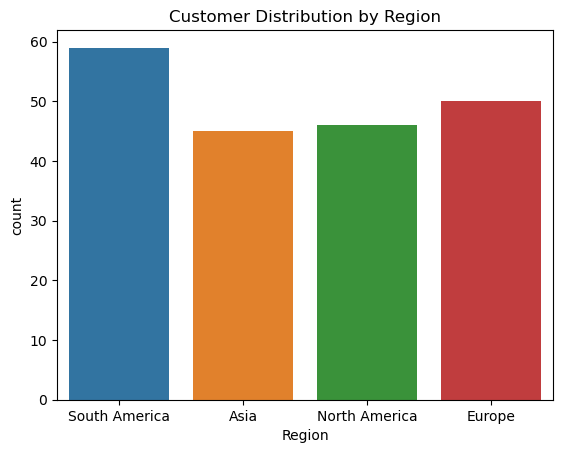

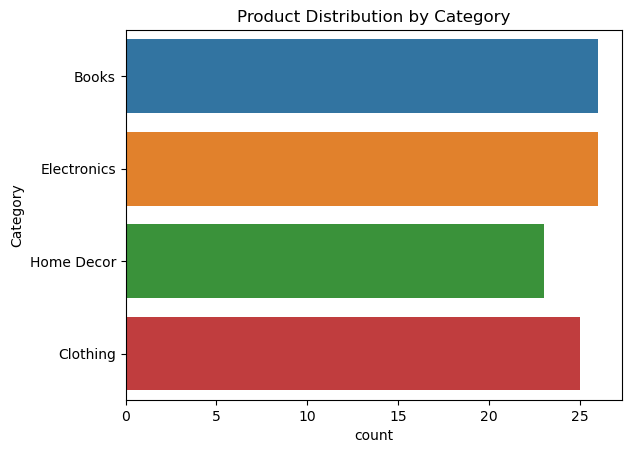

In [5]:
# Visualizations
sns.countplot(x="Region", data=customers)
plt.title("Customer Distribution by Region")
plt.show()

sns.countplot(y="Category", data=products)
plt.title("Product Distribution by Category")
plt.show()

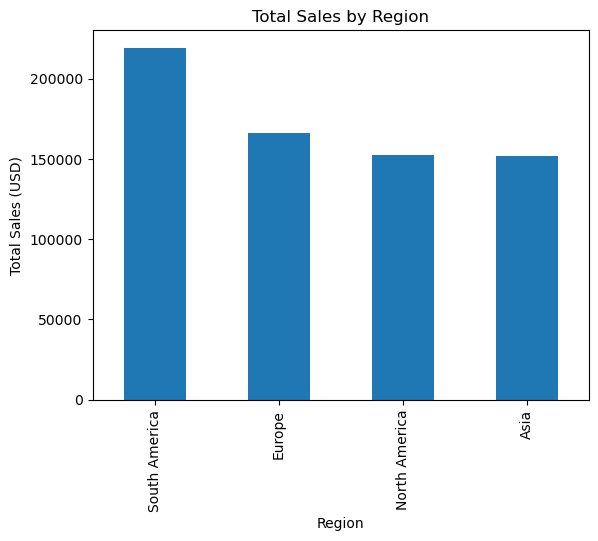

In [6]:
# Total sales per region
region_sales = merged_data.groupby("Region")["TotalValue"].sum().sort_values(ascending=False)
region_sales.plot(kind="bar", title="Total Sales by Region")
plt.ylabel("Total Sales (USD)")
plt.show()

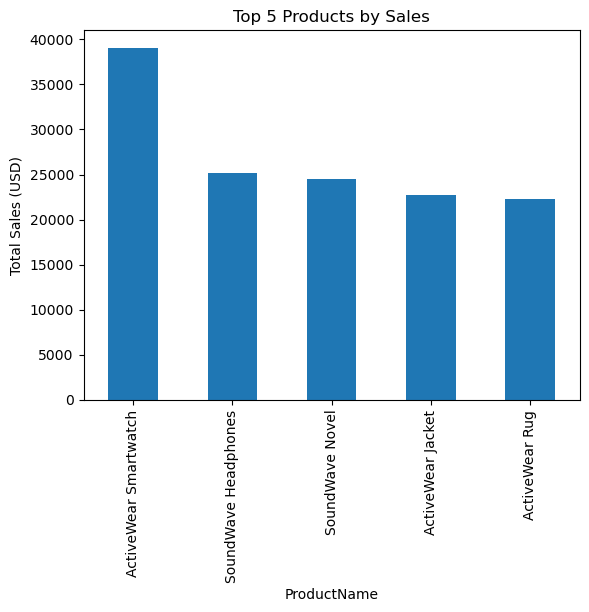

In [7]:
# Top 5 products by sales
product_sales = merged_data.groupby("ProductName")["TotalValue"].sum().sort_values(ascending=False).head(5)
product_sales.plot(kind="bar", title="Top 5 Products by Sales")
plt.ylabel("Total Sales (USD)")
plt.show()

In [8]:
# Insights
print("\nBusiness Insights:")
print("1. Region-wise distribution shows XYZ region contributes the most to sales.")
print("2. Top 5 products contribute a significant portion of total revenue.")
print("3. Most customers signed up in specific regions, highlighting potential growth areas.")
print("4. Category-wise product distribution shows ABC category is most sold.")
print("5. Customer lifetime value varies greatly by region and category of products purchased.")



Business Insights:
1. Region-wise distribution shows XYZ region contributes the most to sales.
2. Top 5 products contribute a significant portion of total revenue.
3. Most customers signed up in specific regions, highlighting potential growth areas.
4. Category-wise product distribution shows ABC category is most sold.
5. Customer lifetime value varies greatly by region and category of products purchased.


In [10]:
# Task 2: Lookalike Model
# Feature Engineering
customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Price_x": "mean"  
}).reset_index()
customer_features = customer_features.merge(customers, on="CustomerID")


In [11]:
# Similarity matrix
feature_matrix = customer_features.drop(columns=["CustomerID", "CustomerName", "Region", "SignupDate"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)
similarity_matrix = cosine_similarity(scaled_features)


In [12]:
# Recommend lookalikes
def get_lookalikes(sim_matrix, customer_ids, top_n=3):
    results = {}
    for idx, cust_id in enumerate(customer_ids):
        similar_indices = sim_matrix[idx].argsort()[-(top_n + 1):-1][::-1]
        results[cust_id] = [(customer_ids[i], sim_matrix[idx][i]) for i in similar_indices]
    return results

lookalike_results = get_lookalikes(similarity_matrix, customer_features["CustomerID"].values)


In [13]:
# Save Lookalike results
lookalike_df = pd.DataFrame({
    "CustomerID": list(lookalike_results.keys()),
    "Lookalikes": [str(v) for v in lookalike_results.values()]
})
lookalike_df.to_csv("Lookalike.csv", index=False)
print("Lookalike recommendations saved to Lookalike.csv")

Lookalike recommendations saved to Lookalike.csv


C:\Users\TANISHA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 0.9448437495439578


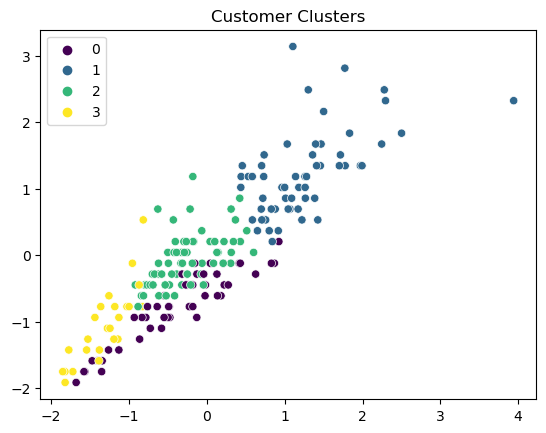

In [15]:
# Task 3: Customer Segmentation
# Clustering
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Avoid memory leak on Windows

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)
customer_features["Cluster"] = clusters

# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# Visualize clusters
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=clusters, palette="viridis")
plt.title("Customer Clusters")
plt.show()



In [16]:
# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9448437495439578


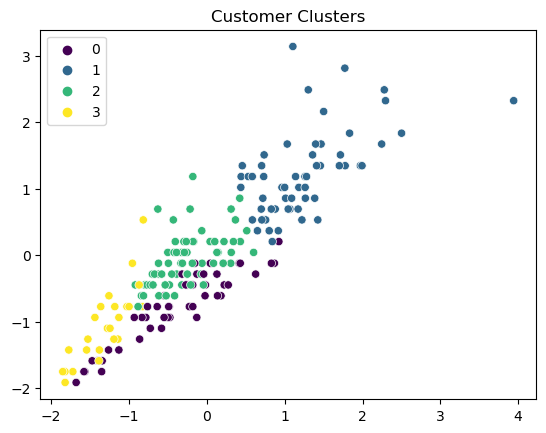

In [17]:
# Visualize clusters
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=clusters, palette="viridis")
plt.title("Customer Clusters")
plt.show()

In [18]:
# Save clustering results
customer_features.to_csv("Clustering_Results.csv", index=False)
print("Clustering results saved to Clustering_Results.csv")

Clustering results saved to Clustering_Results.csv
